In [17]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random

In [18]:
# Define paths
path = 'C:/Users/Admin/Documents/GitHub/msba265-finalstorage/data_storage/Audio/CREAMA-D/AudioWAV'
if not os.path.exists(path):
    raise FileNotFoundError(f"Path does not exist: {path}")

In [19]:
# Collect audio file paths and emotions
audio_path = []
audio_emotion = []
print("Collecting audio file paths and extracting emotions...")
for audio in os.listdir(path):
    full_path = os.path.join(path, audio)
    if os.path.isfile(full_path):
        audio_path.append(full_path)
        emotion = audio.split('_')[2]
        emotion_map = {
            "SAD": "sad",
            "ANG": "angry",
            "DIS": "disgust",
            "NEU": "neutral",
            "HAP": "happy",
            "FEA": "fear"
        }
        audio_emotion.append(emotion_map.get(emotion, "unknown"))


In [20]:
# Create a dataset
emotion_dataset = pd.DataFrame(audio_emotion, columns=['Emotions'])
audio_path_dataset = pd.DataFrame(audio_path, columns=['Path'])
dataset = pd.concat([audio_path_dataset, emotion_dataset], axis=1)
print(f"Dataset created with {len(dataset)} entries.")
print(dataset.head())

Dataset created with 7442 entries.
                                                Path Emotions
0  C:/Users/Admin/Documents/GitHub/msba265-finals...    angry
1  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust
2  C:/Users/Admin/Documents/GitHub/msba265-finals...     fear
3  C:/Users/Admin/Documents/GitHub/msba265-finals...    happy
4  C:/Users/Admin/Documents/GitHub/msba265-finals...  neutral


In [21]:
# Dataset Overview
print("Dataset Overview:")
print(dataset.info())
print("Emotion distribution:\n", dataset['Emotions'].value_counts())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Path      7442 non-null   object
 1   Emotions  7442 non-null   object
dtypes: object(2)
memory usage: 116.4+ KB
None
Emotion distribution:
 Emotions
angry      1271
disgust    1271
fear       1271
happy      1271
sad        1271
neutral    1087
Name: count, dtype: int64


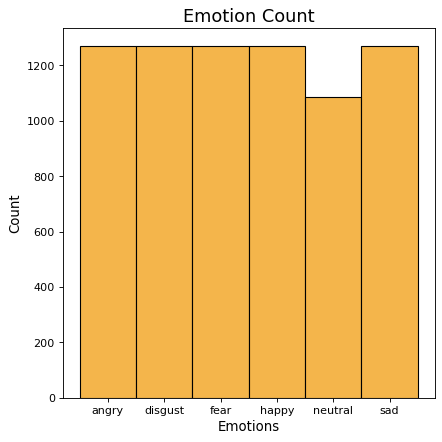

In [22]:
# Visualization of Emotion Distribution
plt.figure(figsize=(6, 6), dpi=80)
sns.histplot(dataset.Emotions, color='#F19C0E')
plt.title("Emotion Count", size=16)
plt.xlabel('Emotions', size=12)
plt.ylabel('Count', size=12)
plt.show()


--- File Duration Analysis ---


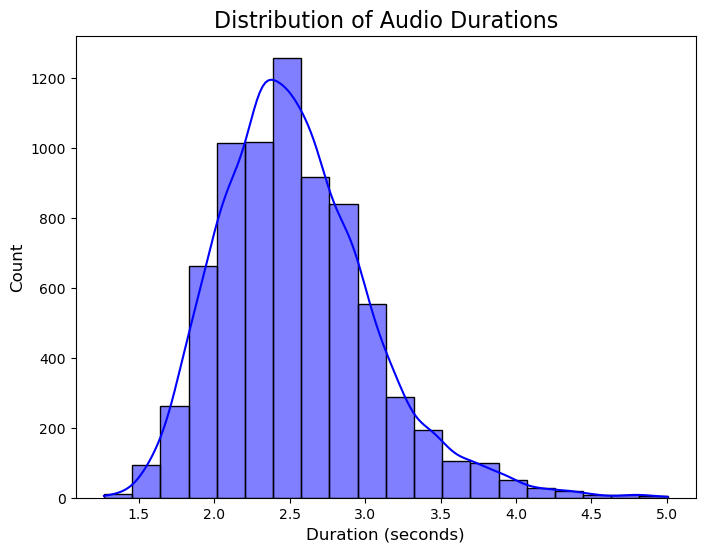

In [23]:
# File Duration Analysis
print("\n--- File Duration Analysis ---")
durations = []
for path in dataset['Path']:
    try:
        data, sr = librosa.load(path, sr=None)
        durations.append(len(data) / sr)
    except Exception as e:
        print(f"Error loading file {path}: {e}")
dataset['Duration'] = durations

plt.figure(figsize=(8, 6))
sns.histplot(durations, bins=20, kde=True, color='blue')
plt.title("Distribution of Audio Durations", fontsize=16)
plt.xlabel("Duration (seconds)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

In [24]:
# Define your augmentations
def awgn(data):
    noise_amp = 0.055 * np.random.uniform() * np.amax(data)
    data += noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sr=44100, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=1/pitch_factor)

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def time_shift(data, sr=44100, shift_limit=1):
    shift_amt = int(random.random() * shift_limit * len(data))
    return np.roll(data, shift_amt)


--- EDA with Augmented MFCCs ---


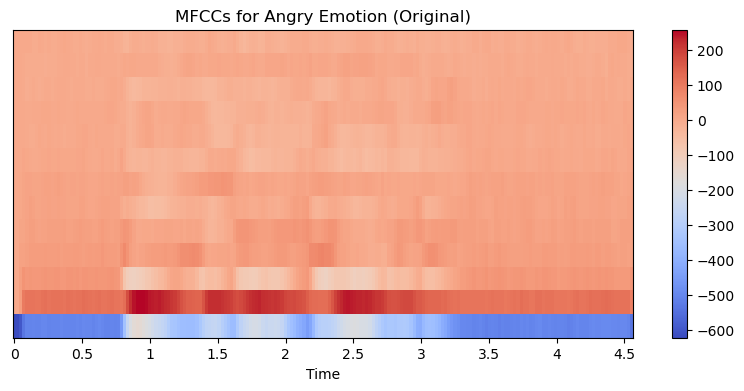

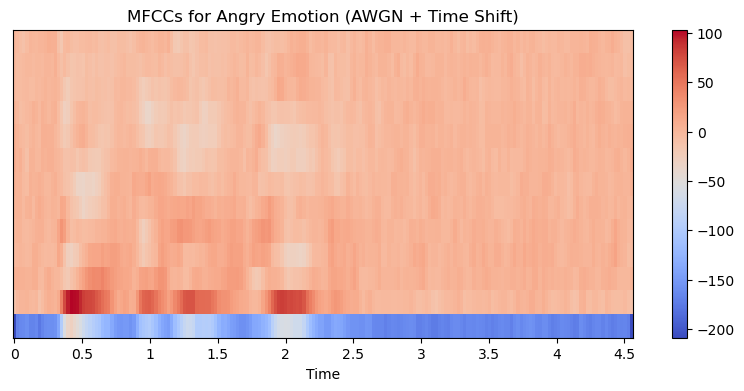

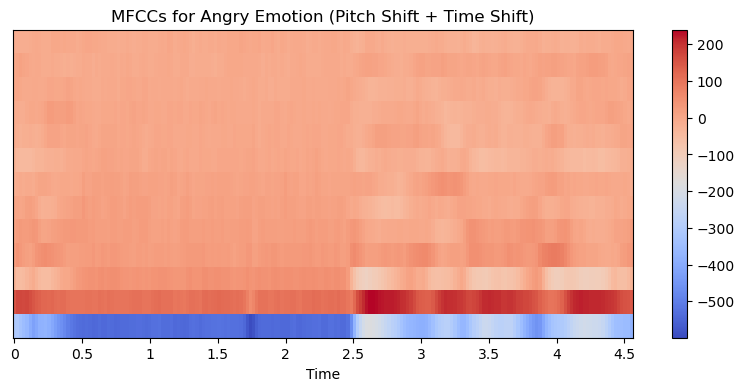

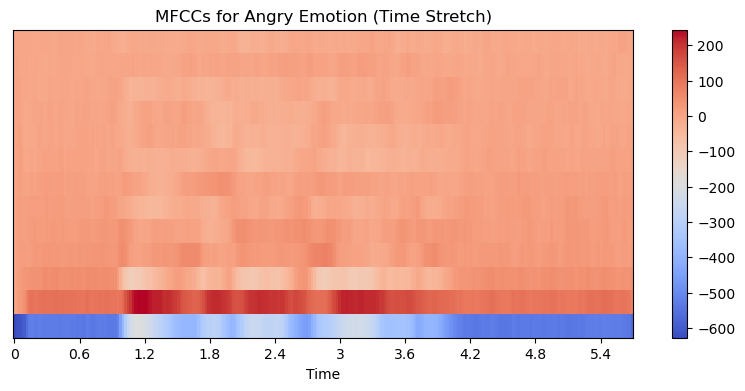

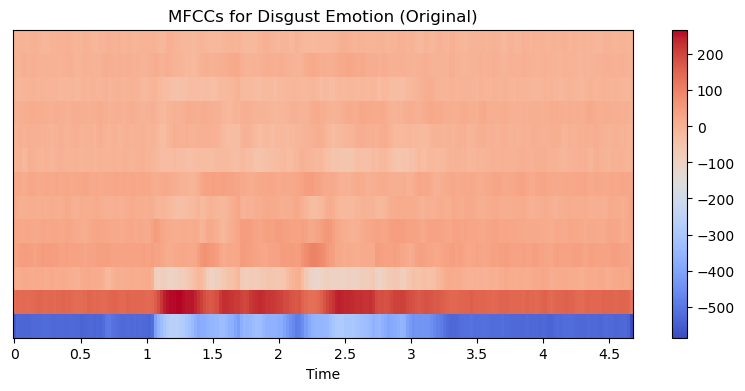

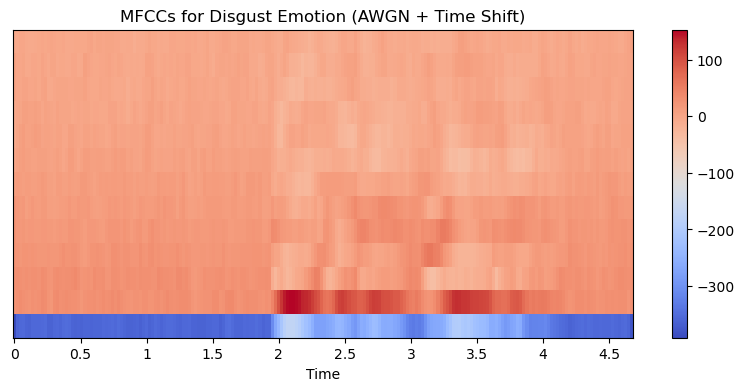

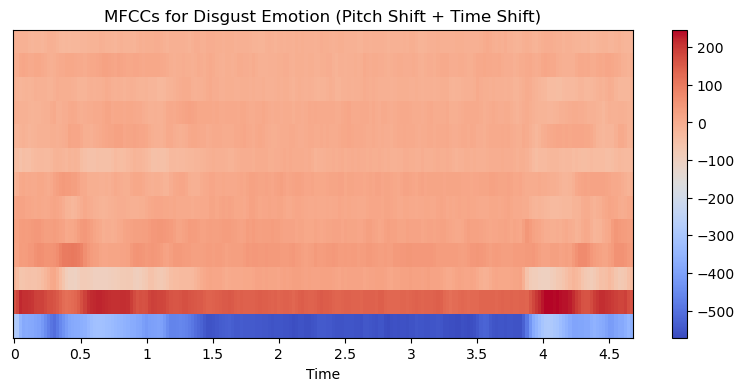

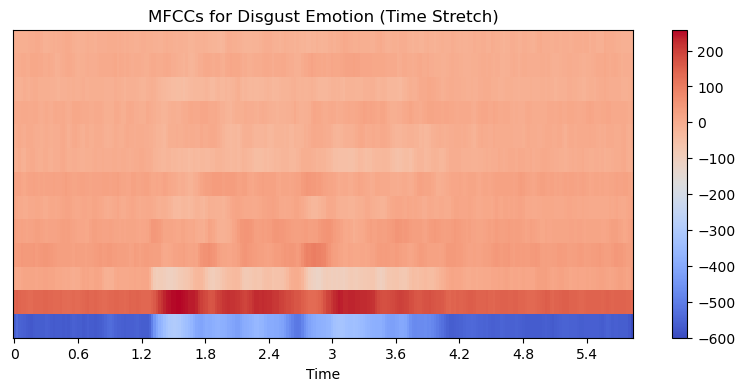

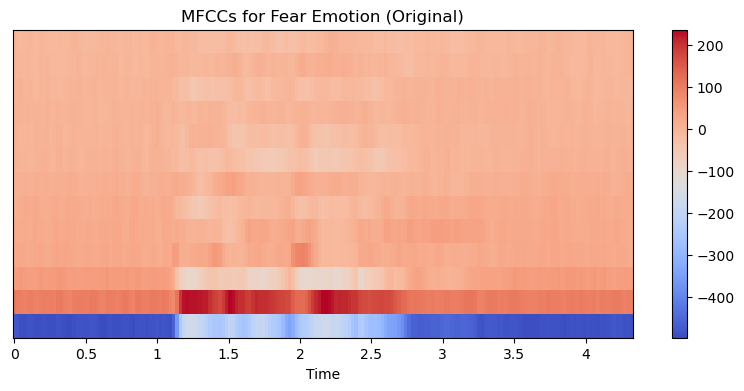

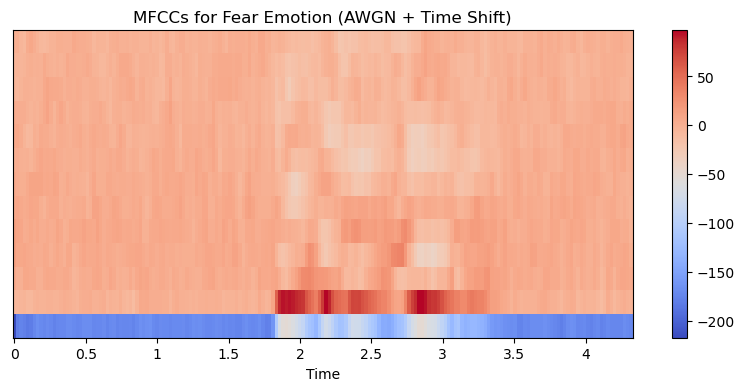

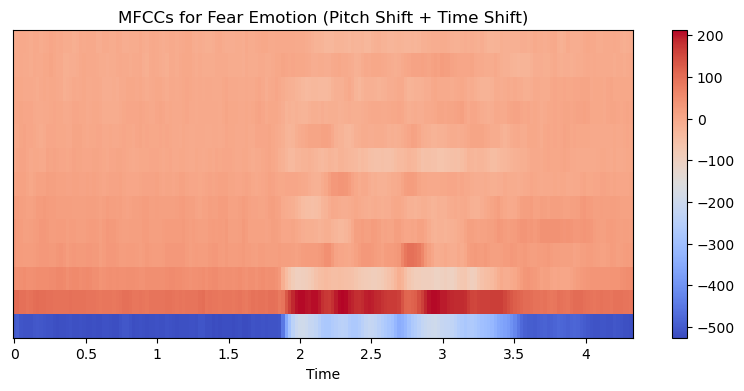

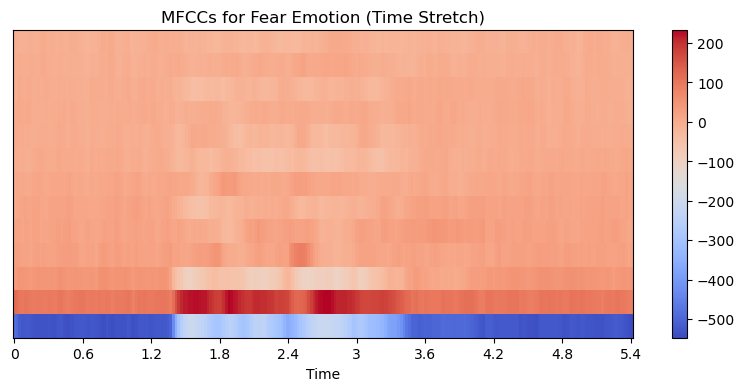

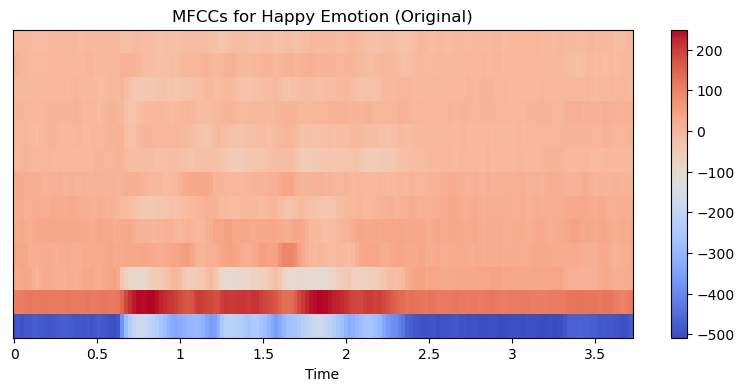

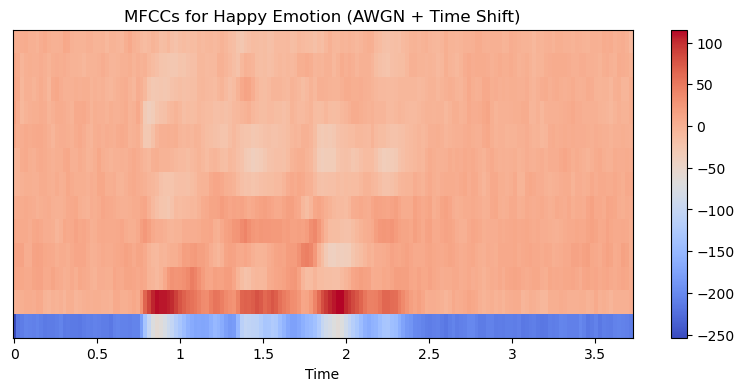

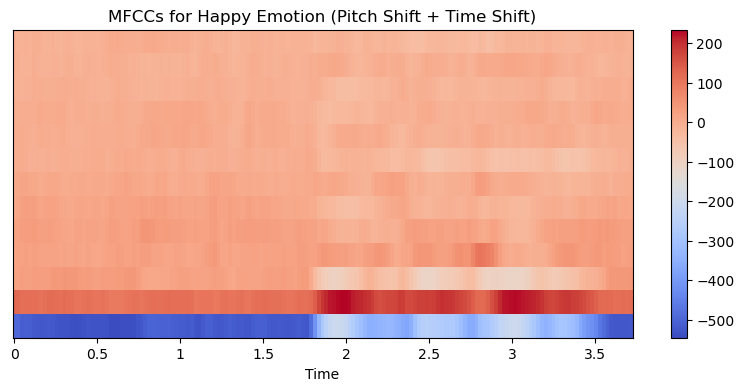

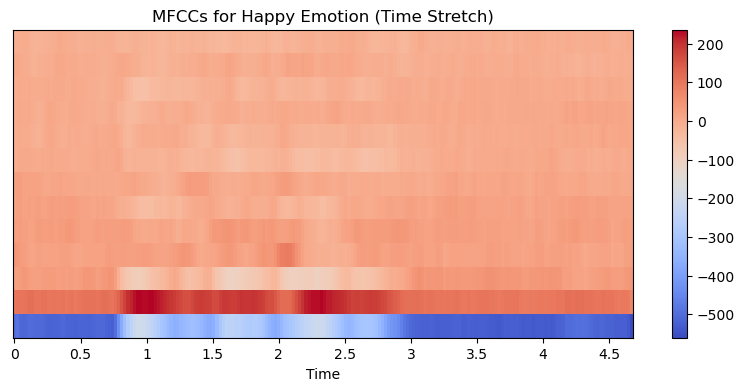

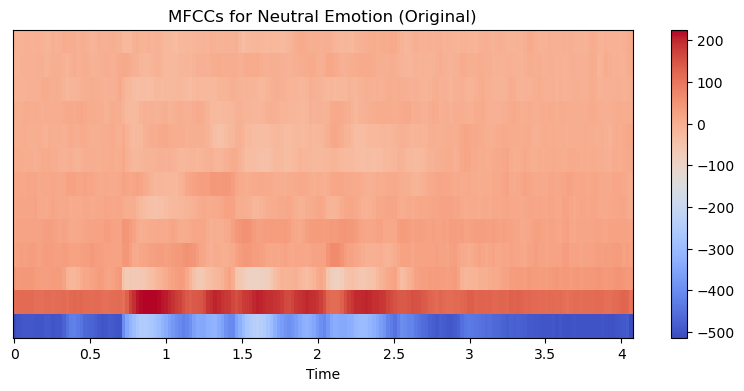

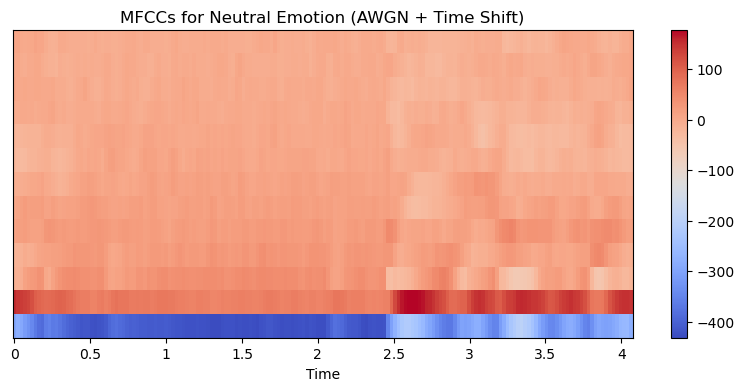

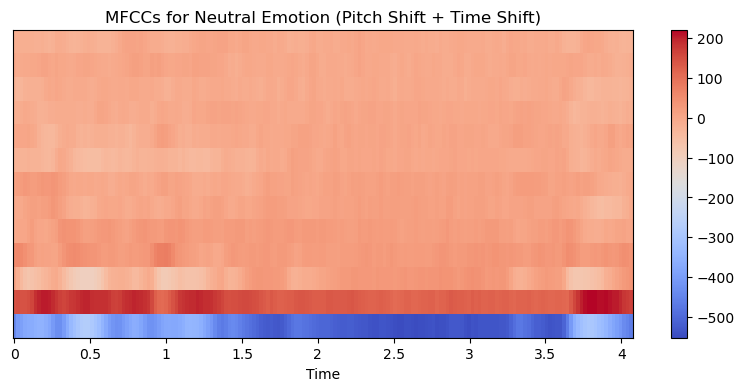

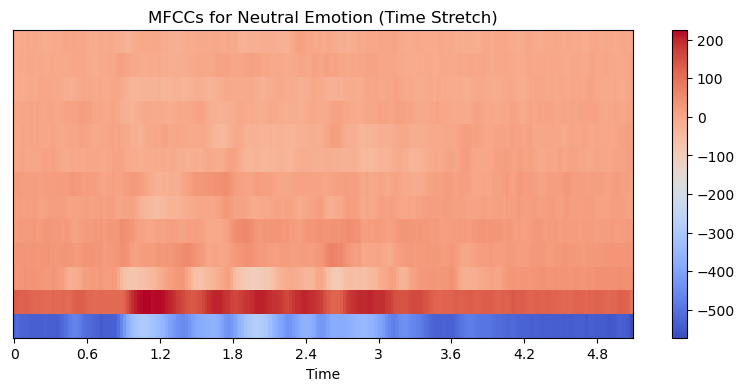

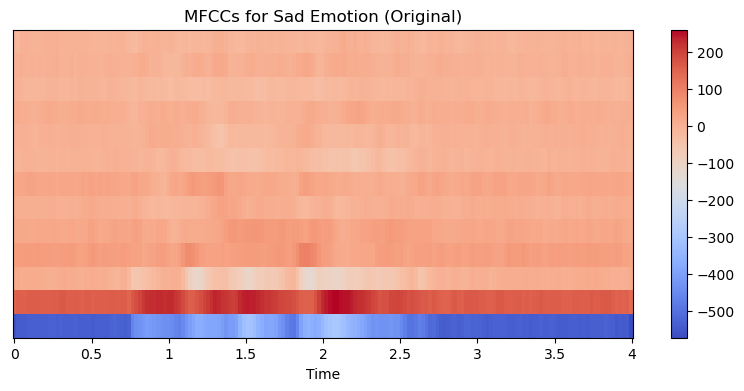

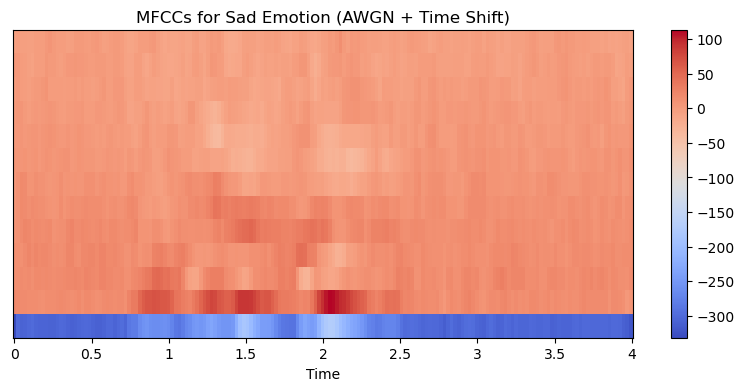

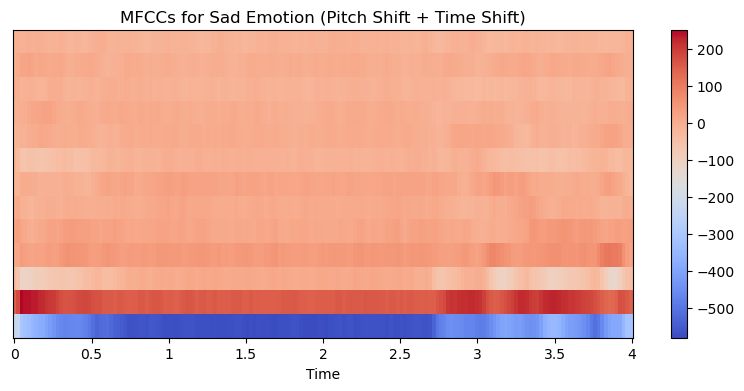

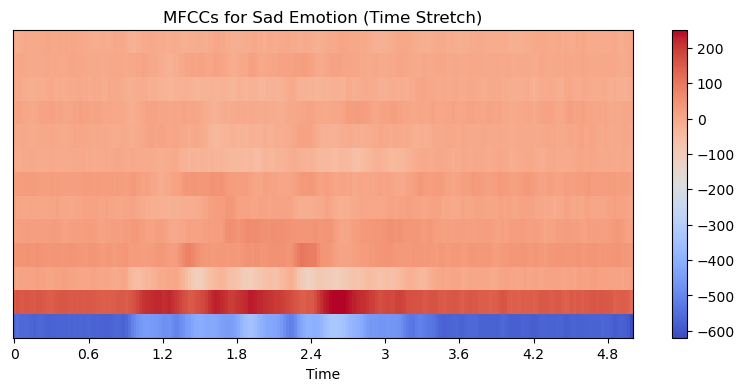

In [25]:
# EDA with Augmented MFCCs
print("\n--- EDA with Augmented MFCCs ---")
for emotion in dataset['Emotions'].unique():
    sample_path = dataset[dataset['Emotions'] == emotion].iloc[0]['Path']
    try:
        # Load original audio
        data, sr = librosa.load(sample_path, sr=44100)
        
        # Augmentation techniques
        augmentations = {
            "Original": data,
            "AWGN + Time Shift": awgn(time_shift(data)),
            "Pitch Shift + Time Shift": pitch(time_shift(data)),
            "Time Stretch": stretch(data),
        }
        
        # Plot MFCCs for each augmentation
        for aug_name, aug_data in augmentations.items():
            mfcc = librosa.feature.mfcc(y=aug_data, sr=sr, n_mfcc=13)
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(mfcc, x_axis='time', cmap='coolwarm')
            plt.colorbar()
            plt.title(f"MFCCs for {emotion.capitalize()} Emotion ({aug_name})")
            plt.show()
    
    except Exception as e:
        print(f"Error processing MFCC for {emotion}: {e}")

In [26]:
# Outlier Detection
print("\n--- Outlier Detection ---")
duration_threshold = dataset['Duration'].quantile(0.99)
duration_outliers = dataset[dataset['Duration'] > duration_threshold]
print(f"Files with duration above {duration_threshold:.2f} seconds:")
print(duration_outliers)


--- Outlier Detection ---
Files with duration above 4.04 seconds:
                                                   Path Emotions  Duration
204   C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.404375
216   C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.237563
228   C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.270937
232   C:/Users/Admin/Documents/GitHub/msba265-finals...      sad  4.371062
254   C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.838188
...                                                 ...      ...       ...
6745  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.337688
6757  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.204187
6769  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.404375
7249  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.537875
7273  C:/Users/Admin/Documents/GitHub/msba265-finals...  disgust  4.070750

[70 rows x 3 columns]


In [27]:
# Cross-Validation Check
print("\n--- Cross-Validation Check ---")
train, test = train_test_split(dataset, test_size=0.2, stratify=dataset['Emotions'], random_state=42)
print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print("\nTraining set class distribution:\n", train['Emotions'].value_counts())
print("\nTest set class distribution:\n", test['Emotions'].value_counts())


--- Cross-Validation Check ---
Training set size: 5953
Test set size: 1489

Training set class distribution:
 Emotions
angry      1017
sad        1017
disgust    1017
fear       1017
happy      1016
neutral     869
Name: count, dtype: int64

Test set class distribution:
 Emotions
happy      255
angry      254
fear       254
disgust    254
sad        254
neutral    218
Name: count, dtype: int64
